# Проект: вариант 1. Cадовников Алексей
## Импортируем все необходимые библиотеки

In [739]:
import pandas as pd
import datetime
from datetime import timedelta
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np
import requests
import urllib
from urllib.parse import urlencode
import json
plt.style.use('ggplot')

from tqdm.auto import tqdm
from scipy.stats import norm

# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и иметь структуру и фнкция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [740]:
#Считываем данные о времени захода пользователей в игру
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')

In [741]:
#Проверяем как данные выглядят на вид
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [742]:
#Проверка типов данных
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [743]:
#Размер данных
auth_data.shape


(9601013, 2)

In [744]:
#Проверка на дубли в данных
auth_data.duplicated().sum()

0

In [745]:
#Проверка на незаполненные строки
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [746]:
#Перевод даты в корректный вид
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit = 's').dt.date

In [747]:
#Корректный вид датафрейма
auth_data

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [748]:
#Считываем данные о времени регистрации
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')

In [749]:
#Проверяем как данные выглядят на вид
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [750]:
#Проверка типов данных
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [751]:
#Размер данных
reg_data.shape

(1000000, 2)

In [752]:
#Проверка на дубли в данных
reg_data.duplicated().sum()

0

In [753]:
#Проверка на незаполненные строки
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [754]:
#Перевод даты в корректный вид
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit = 's').dt.date

In [755]:
#Корректный вид датафрейма
reg_data

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5
...,...,...
999995,2020-09-23,1110618
999996,2020-09-23,1110619
999997,2020-09-23,1110620
999998,2020-09-23,1110621


In [756]:
#Общий вид функции Retention_rate с учетом входных параметров:
#reg_data - входной датафрейм с временем регистрации
#auth_data - входной датафрейм с временем захода пользователей
#date_start - дата, с которой идет отсчет Retention
#date_days - количество дней от даты start, в которые учитываем Retention Rate

def Retention_rate(reg_data, auth_data, date_start, days):
    date_start = pd.to_datetime(date_start) #корректный формат дата начала подсчета Retention
    date_end = date_start + pd.Timedelta(days = days) #корректный формат даты окончания подсчета Retention
    #Объединение входных датафреймов в один по ключу "uid" и фильтрация фиксированного периода
    data = auth_data.merge(reg_data, how = 'left', on = 'uid').query('reg_ts >= @date_start and auth_ts <= @date_end')\
        .groupby(['reg_ts', 'auth_ts'], as_index = False)\
        .agg(user = ('uid', 'nunique')).rename(columns = {'reg_ts': 'registration_date'})
    #Разница в днях между вхождением в приложение и датой регистрации
    data['days'] = (data['auth_ts'] - data['registration_date']).dt.days
    #Построение таблицы когорт
    final_retention = data.pivot_table(index = 'registration_date', columns = 'days', values = 'user')
    final_retention = final_retention.divide(final_retention.iloc[:, 0], axis = 0)
    final_retention = final_retention.drop(final_retention.columns[0], axis = 1)
    #Визуализация
    plt.figure(figsize = (20, 10))
    ax = sns.heatmap(final_retention, annot = True, cmap = "Blues", fmt = '.1%', cbar = False)
    sns.despine()
    return final_retention

C:\Users\Alexei\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


days,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
registration_date,,,,,,,,,,,,,,,,,,,,
2017-08-01,0.028226,0.040323,0.056452,0.060484,0.060484,0.044355,0.056452,0.060484,0.048387,0.056452,0.048387,0.040323,0.064516,0.036290,0.052419,0.040323,0.024194,0.064516,0.040323,0.028226
2017-08-02,0.016064,0.028112,0.052209,0.060241,0.088353,0.072289,0.064257,0.040161,0.068273,0.076305,0.060241,0.064257,0.048193,0.048193,0.052209,0.036145,0.040161,0.052209,0.044177,NaN
2017-08-03,0.024096,0.044177,0.052209,0.076305,0.068273,0.084337,0.048193,0.040161,0.052209,0.060241,0.080321,0.084337,0.064257,0.052209,0.064257,0.068273,0.056225,0.036145,NaN,NaN
2017-08-04,0.044000,0.040000,0.056000,0.048000,0.052000,0.104000,0.052000,0.040000,0.040000,0.080000,0.084000,0.052000,0.040000,0.044000,0.056000,0.040000,0.068000,NaN,NaN,NaN
2017-08-05,0.032000,0.036000,0.048000,0.060000,0.076000,0.064000,0.068000,0.032000,0.064000,0.056000,0.068000,0.048000,0.052000,0.044000,0.060000,0.024000,NaN,NaN,NaN,NaN
2017-08-06,0.015936,0.043825,0.023904,0.059761,0.043825,0.099602,0.067729,0.023904,0.043825,0.035857,0.043825,0.043825,0.035857,0.043825,0.039841,NaN,NaN,NaN,NaN,NaN
2017-08-07,0.011952,0.023904,0.027888,0.027888,0.063745,0.051793,0.055777,0.023904,0.047809,0.035857,0.043825,0.047809,0.039841,0.007968,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-08,0.023904,0.051793,0.047809,0.055777,0.067729,0.063745,0.071713,0.035857,0.039841,0.051793,0.047809,0.047809,0.063745,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-09,0.003968,0.059524,0.019841,0.031746,0.051587,0.059524,0.055556,0.027778,0.023810,0.043651,0.063492,0.043651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


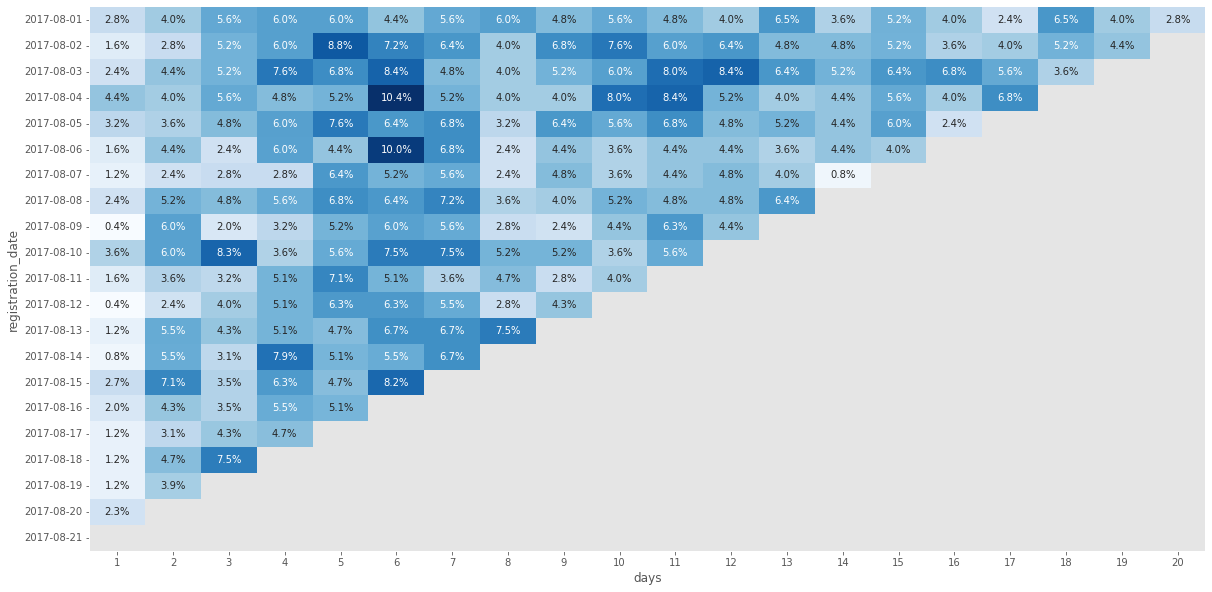

In [757]:
Retention_rate(reg_data, auth_data, '2017-08-01', 20)

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

# Какой набор предложений можно считать лучшим?

In [758]:
# Подготовка для скачивания данных с внешней ссылки (конструкция с stackoverflow)
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'  
final_url = base_url + urlencode(dict(public_key=public_key))
# Считываем данные из файла
response = requests.get(final_url)
path = json.loads(response.text)['href']

# Записываем данные в датафрейм
df = pd.read_csv(path, sep=';')

In [759]:
#a - контрольная группа
#b - тестовая группа
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [760]:
#Проверка типов данных
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [761]:
#Размер данных
df.shape

(404770, 3)

In [762]:
#Проверка на дубли в данных
df.duplicated().sum()

0

In [763]:
#Проверка на незаполненные строки
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [764]:
#Количество уникальных пользователей (совпадает с количеством строк) => таблица из всех неповторяющихся пользователей
df.user_id.nunique()

404770

In [765]:
#Количество уникальных значений прибыли
df.revenue.nunique()

1477

In [766]:
#Описательная статистика revenue по группам
df.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


Получается, что. 
1) в группе (b) ARPU выше на 5,27% (mean) чем в контрольной группе (a) (подтверждается условие задачи в данных)

2) стандартное отклонение (std) в группе (a) выше в 3,2 раза чем в группе (b)

3) максимальное значение в группе (a) в 9,35 раза выше чем в группе (b), что наводит на мысль, о больших выбросах

In [767]:
#Количество заработанных денег с каждой группы
df.groupby('testgroup').agg({'revenue': 'sum'})

,revenue
testgroup,
a,5136189
b,5421603


In [768]:
#Разбиение датафрейма на тестовые группы
df_a = df.query('testgroup == "a"')

In [769]:
#Сумма дохода с группы a
revenue_a = df_a.revenue.sum()

In [770]:
#Разбиение датафрейма на тестовые группы
df_b = df.query('testgroup == "b"')

In [771]:
#Сумма дохода с группы b
revenue_b = df_b.revenue.sum()

In [772]:
#Разница доходов с группы b и группы a
revenue_b - revenue_a

285414

Тестовая группа (b) принесла денег больше контрольной группы (a) на 285414 

In [773]:
#Описание пользователей, пользующих платными услугами
df.query('revenue > 0').groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Получается, что:
1) Среднее ARPPU (доход на каждого платящего пользователя) в группе (b) выше чем в группе (a) на 12,75%

2) Стандартное отклонение (std) у группы (a) выше чем у (b) в 15,8 раза

3) Минимальное значение у группы (a) в 10 раз меньше чем у группы (b)

4) 25, 50, 75 перцентили у группы (a) также примерно в 10 раз меньше в группе (a) чем у группы (b)

5) Максимальное значение у группы (a) в 9,35 раза меньше чем у группы (b)

Пункты 2-5 говорят о больших отклонениях соответствующих значений, что наталкивает на мысль о нерепрезентативности

In [774]:
#Дисперсия группы (a) платящих пользователей
df_a.query('revenue > 0').revenue.var()

81885120.63985239

In [775]:
#Дисперсия группы (b) платящих пользователей
df_b.query('revenue > 0').revenue.var()

327893.331536567

Как мы видим, дисперсии довольно высокие значения, а также огромная разница, попробуем понять, какие значения привели к такой огромной дисперсии

In [776]:
#Количество пользователей, принесших денег на сумму более 30 тысяч
rich_user_count = df_a.query('revenue > 30000').revenue.agg({'revenue': 'count'})

In [777]:
rich_user_count

revenue    123
Name: revenue, dtype: int64

In [778]:
#Средняя сумма, которую принесли данные пользователи
rich_user_mean = df_a.query('revenue > 30000').revenue.agg({'revenue': 'mean'})

In [779]:
rich_user_mean

revenue    37319.121951
Name: revenue, dtype: float64

In [780]:
rich_user_count / df_a.query('revenue > 0').revenue.count()

revenue    0.063797
Name: revenue, dtype: float64

In [781]:
df_a.query('revenue > 30000').revenue.agg({'revenue': 'sum'}) / df_a.revenue.sum()

revenue    0.893708
Name: revenue, dtype: float64

Получается, что:
всего лишь 123 пользователя (6,37% платящих пользователей), принесший каждый в среднем 37319 денег, принесли 89,4% дохода всей группы (a)

In [782]:
#Доля платящих пользователей в группе (a)
df_a.query('revenue > 0').revenue.count() / df_a.revenue.count()

0.009539690157988749

In [783]:
#Доля платящих пользователей в группе (b)
df_b.query('revenue > 0').revenue.count() / df_b.revenue.count()

0.008906235351586593

In [784]:
#Разница в процентах между суммами в группах платящих
df_b.query('revenue > 0').revenue.count() / df_a.query('revenue > 0').revenue.count() - 1

-0.0637966804979253

In [785]:
#Разница в процентах между суммами в группах
df_b.revenue.sum() / df_a.revenue.sum() - 1

0.055569216786999

Доля платящих пользователей в обоих группах очень близка по значению, но количество платящих пользователей в группе b меньше на 6,37%, однако доход от группы b больше на 5,5%

C:\Users\Alexei\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

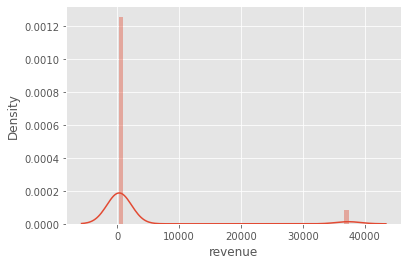

In [786]:
#Гистограмма группы a
sns.distplot(df_a.query('revenue > 0').revenue)

C:\Users\Alexei\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

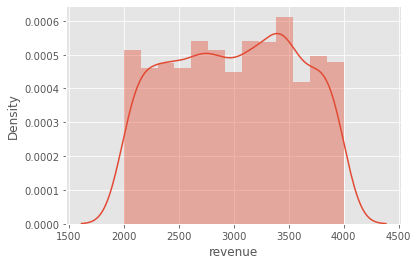

In [787]:
#Гистограмма группы b
sns.distplot(df_b.query('revenue > 0').revenue)

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

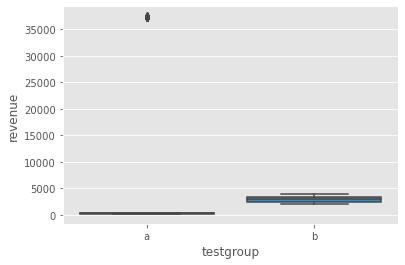

In [788]:
sns.boxplot(data = df.query('revenue > 0'), x = 'testgroup', y = 'revenue')

Получается, что:
# Вывод на 1 вопрос:
    Различия между группами явно выражены. Само распределение значений дохода в групаах совершенно разное: в группе a очень много недоходных пользователей и совсем немного сверхдоходных, а в группе b наоборот среднедоходные.
    
    Исходя из этого очень сложно отвечать на первый поставленный вопрос, какой же набор предложений лучше, потому что на основе выше проведенного анализа выборки кажутся нерепрезентативными. 
    
    В идеальном случае: для корректного ответа на поставленный вопрос, необходимо заного сплитовать группы более качественно и провести новый A/B тест

# Какие метрики стоит проанализировать для принятия правильного решения и как?

Для выбора лучшего набор предложений будем сравнивать результаты тестов основываясь на метриках монетизации: 

ARPU ((Average revenue per user) - средний доход с пользователя), 

ARPPU ((Average revenue per paying user) - средний доход с платящего пользователя), 

CR ((Conversion Rate) - коэффициент конверсии пользователя в покупателя). 

In [789]:
df_metrics = df

In [790]:
df_metrics['paying'] = df_paying['revenue'].apply(lambda x: 1 if x > 0 else 0)
df_c = df_metrics

In [791]:
#Подсчет метрик по группам
df_metrics = df_metrics.groupby('testgroup', as_index = False).agg(
            user = ('user_id', 'count'),
            paying_users = ('paying', 'sum'),
            revenue = ('revenue', 'sum'))
df_metrics['ARPU'] = df_metrics.revenue / df_metrics.user
df_metrics['ARPPU'] = df_metrics.revenue / df_metrics.paying_users
df_metrics['CR'] = (df_metrics.paying_users / df_metrics.user)*100

In [792]:
df_metrics

,testgroup,user,paying_users,revenue,ARPU,ARPPU,CR
0,a,202103,1928,5136189,25.413720,2663.998444,0.953969
1,b,202667,1805,5421603,26.751287,3003.658172,0.890624


Получается, что:
    в группе b ARPU и ARPPU имеет немного значение выше чем в группе a, при этом CR имеет обратную характеристику.

Для проверки значимости изменений в ключевых метриках (ARPU, ARPPU, CR):
    
    не будем использовать T-test Стьюдента по причине того, что распределение групп не является нормальным, а также из-за присутствия выбросов в данных.
    
    не будем использовать Mann–Whitney U test по причине того, что результаты сложно интерпретируемы для бизнеса, так как сравнивает не средние значения, а их ранги.
    
    будем использовать Bootstrap по причине того, что он менее требователен к данным и за счет созданий подвыборок нивелируется влияние выбросов.
    

In [793]:
# Функция из лекции

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [794]:
df_bootstrap = df.copy()

  0%|          | 0/1000 [00:00<?, ?it/s]

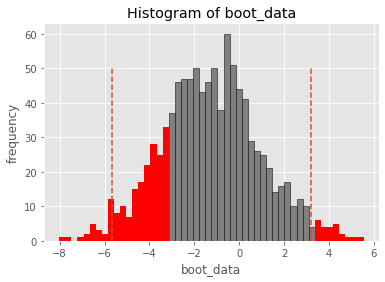

In [795]:
ARPU_bootstrap = get_bootstrap(df_bootstrap.query('testgroup == "a"').revenue, df_bootstrap.query('testgroup == "b"').revenue,
                              boot_it = 1000, statistic = np.mean)

In [796]:
ARPU_bootstrap["p_value"]

0.5666879380855852

Получается, что:

    ARPU p-value > 0.05, при этом находится в доверительном интервале => Статистически значимых различий нет.

  0%|          | 0/1000 [00:00<?, ?it/s]

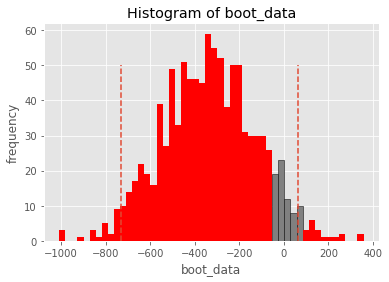

In [797]:
ARPPU_bootstrap = get_bootstrap(df_bootstrap.query('testgroup == "a" & revenue > 0').revenue, df_bootstrap.query('testgroup == "b" & revenue > 0').revenue,
                              boot_it = 1000, statistic = np.mean)

In [798]:
ARPPU_bootstrap["p_value"]

0.11012207026663258

Получается, что:
    
    ARPPU p-value > 0.05, при этом находится в доверительном интервале => Статистически значимых различий нет.

In [799]:
CR_a = df_c.groupby('testgroup').agg(nopaying = ('paying', 'count'), paying = ('paying', 'sum'))

In [800]:
CR_a_1 = CR_a.query('testgroup == "a"')

In [801]:
CR_a_1

,nopaying,paying
testgroup,,
a,202103,1928


In [802]:
CR_b_1 = CR_a.query('testgroup == "b"')

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Alexei\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


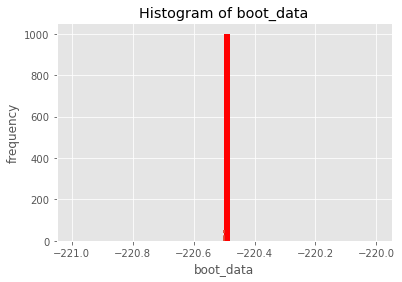

In [803]:
cr_bootstrap = get_bootstrap(CR_a_1, CR_b_1 ,
                              boot_it = 1000, statistic = np.mean)

Поскольку для CR bootstrap не подходит, воспользуемся методом хи-квадрат

In [804]:
stat, p, dof, expected = scipy.stats.chi2_contingency(CR_a)
p

0.03824373651044168

Получается, что:

    CR p-value < 0.05 => Различия являются статистически значимыми

# Вывод на 2 вопрос:
    Для принятия решения были проанализированы метрики ARPU, ARPPU, CR (см. анализ выше). Основываясь на этом анализе, несмотря на статистически незначимые различия в обоих группах по метрикам ARPU и ARPPU, результат конверсии в покупку CR статистически значимый, причем CR в группе (a) ощутимо выше, чем в группе (b), набор предложений из группы (a) выглядит немного более привлекательным. Но поскольку в группе a достаточно высокие выбросы, а также очень разная прослойка пользователей в обоих группах (в группе (a) либо нет покупок, либо малое количество пользователей покупает на суммарно высокие суммы, в группе (b) почти все пользователи по суммам покупок лежат в диапазоне от 2000 до 5000) и поэтому хочется пересплитовать данные по новому и снова провести A/B тест, для того чтобы окончательно принять максимально верное решение.

# Задание 3
1) В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

2) Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?




--------------------------------------------------------------------------------------------------------------------------------
1) Подобные тематические события (ивенты) проводятся для того, чтобы повышать вовлеченность и удерживать пользователей, чтобы в итоге это отразилось на более высоких доходах. Метрики необходимы для того, чтобы оценить качественные показатели тех или иных изменений.

Поскольку тематические события проводятся раз в месяц, то необходима метрика:
    
        MAU (Monthly Active Users) - количество уникальных пользователей за месяц без учета повторных сессий.
            
Данная метрика будет показывать общую ситуацию в продукте и прирост или сокращение активных уникальных пользователей. Но на только одну данную метрику нельзя полагаться для принятия решения, поскольку если идет постоянный приток новых пользователей, то MAU будет расти, но это не гарантирует повышение других денежных метрик и суммарного дохода от игры в целом.
        
Поскольку в рамках тематического события необходимо удерживать пользователей, то необходима метрика:
    
       RR (Retention rate) - коэффициент удержания пользователей.
       
Данная метрика будет показывать как хорошо каждый ивент удерживает пользователей (насколько много пользователей возвращается в игру), если метрика будет показывать низкие значения относительно предыдущих тематических событий, то это будет напрямую говорить о том, что необходимо что-то подправлять в текущем ивенте.
        
Также понадобятся следующие метрики:
    
        SR (Stickiness ratio) - коэффициент частоты, с которой пользователь взаимодействует с продуктом. SR = DAU/MAU. 
        
        
        Event CR (Event Conversion Rate) - коэффициент конверсии участия пользователей в событии. 
        
Данная метрика будет показывать как много пользователей из всех участвуют в тематическом событии, чем больше показатель, тем больше вовлеченность пользователей
        
        ASD (Average Session Duration) - это среднее время сессий за определенное время. 
        
Данная метрика будет нужна для оценки того, сработала ли вообще идея ивента - увеличилось ли время в игре проводимое пользователями или нет?
        
        CR (из начала прохождения ТС в получение бонусов) - коэффициент конверсии, как много пользователей прошли весь ивент и получили бонусы.
        
Если ивент будет очень сложный, то немного пользователей дойдут до конца и получат бонусы, поэтому для таких характеристик очень полезная метрика.
        
        ARPU & ARPPU (Average Revenue per User & Average Revenue per Paying  User) - средний доход на пользователя & средний доход на платящего пользователя. 
        
Основные метрики, ради которых и проводятся все мероприятия. Эти метрики показывают, повлияло ли проведение тематического события на увеличение средней доходности от пользователей.


--------------------------------------------------------------------------------------------------------------------------------
2) Если усложняется механизм прохождения ивента, то всё равно выше описанные метрики остаются актуальными, но для более точных оценок требуется сравнение метрик ДО внедрения усложненного механизма и ПОСЛЕ, чтобы более эффективно оценить влияние усложнение механизма прохождения тематического события.  
